In [1]:
import sys
sys.path.append('/home/lizz_lab/cse12232433/project/colmena/multisite_')
from my_util.multi_node_config import create_executor_from_config
log_dir = r'~/tmp'
config,node_resources = create_executor_from_config("/home/lizz_lab/cse12232433/project/colmena/multisite_/my_util/slurm_resources.ini",log_dir)
print(config)
print(node_resources)

def get_total_resources(node_resources):
    aggregated_resources = {}
    
    # gateher total resources from all node
    for resource in node_resources:
        for key, value in node_resources[resource].items():
            if key in aggregated_resources:
                aggregated_resources[key] += value
            else:
                aggregated_resources[key] = value
    return aggregated_resources

total = get_total_resources(node_resources)
print(total)

Config(
    app_cache=True, 
    checkpoint_files=None, 
    checkpoint_mode=None, 
    checkpoint_period=None, 
    executors=[HighThroughputExecutor(
        address='login02', 
        address_probe_timeout=None, 
        available_accelerators=['0', '1', '2', '3'], 
        block_error_handler=True, 
        cores_per_worker=1.0, 
        cpu_affinity='none', 
        heartbeat_period=30, 
        heartbeat_threshold=120, 
        interchange_port_range=(55000, 56000), 
        label='gpu001', 
        launch_cmd='process_worker_pool.py {debug} {max_workers} -a {addresses} -p {prefetch_capacity} -c {cores_per_worker} -m {mem_per_worker} --poll {poll_period} --task_port={task_port} --result_port={result_port} --logdir={logdir} --block_id={{block_id}} --hb_period={heartbeat_period} {address_probe_timeout_string} --hb_threshold={heartbeat_threshold} --cpu-affinity {cpu_affinity} --available-accelerators {accelerators} --start-method {start_method}', 
        max_workers=56, 
        m

In [16]:
task_allocation_node = {'node1':["task1","task2","task3"],"node2":["task4","task5","task6"]}
for key,value in task_allocation_node.items():
    print(key)
    print(value)


node1
['task1', 'task2', 'task3']
node2
['task4', 'task5', 'task6']


In [ ]:
import psutil

# 获取CPU核心数量
num_cores = psutil.cpu_count(logical=False)

# 循环获取每个CPU核的利用率
for i in range(num_cores):
    cpu_percent = psutil.cpu_percent(interval=1, percpu=True)
    print(f"CPU核心 {i+1} 的利用率: {cpu_percent[i]}%")

In [ ]:
import psutil
import os 
import subprocess
cpu_list = [10,11,12,13]

psutil.Process().cpu_affinity(cpu_list)
process = subprocess.Popen(['python3','simple_test.py'])

while process.poll() is None:
    # cpu_percent = psutil.Process(process.pid).cpu_percent(interval=1)
    cpu_percent = psutil.cpu_percent(interval=1,percpu=True)
    for core,percent in enumerate(cpu_percent):
        if core in cpu_list:
            print(f"核心{core}的利用率: {percent}%")
    print(f"新程序在CPU上的利用率: {cpu_percent}%")
    
    # 等待新程序运行结束
process.wait()

In [6]:
from colmena.thinker import BaseThinker, result_processor, task_submitter, ResourceCounter
from colmena.queue import PipeQueues
from colmena.models import Result

from colmena.task_server import ParslTaskServer
from config import csecluster_RT_scale as make_config

"""Example from the README"""

##  Building the Thinker
from random import random

# Build queues to connect Thinker and Doer
queues = PipeQueues()


class Thinker(BaseThinker):

    def __init__(self, queues, num_workers: int, num_guesses=100):
        super().__init__(queues, ResourceCounter(num_workers))
        self.best_result = None
        self.answer = -10  # A (bad) starting guess
        self.num_guesses = num_guesses

    @task_submitter()
    def submit_task(self):
        """Submit a new guess close to the current best whenever a node is free"""
        self.queues.send_inputs(self.answer - 1 + 2 * random(), method='simulate')

    @result_processor()
    def store_result(self, result: Result):
        """Update best guess whenever a simulation finishes"""
        assert result.success, result.failure_info
        # Update the best result
        if self.best_result is None or result.value > self.best_result:
            self.answer = result.args[0]
            self.best_result = result.value
        self.rec.release()  # Mark that a node is now free

        # Determine if we are done
        self.num_guesses -= 1
        if self.num_guesses <= 0:
            self.done.set()


thinker = Thinker(queues, 8)

### Building the doer
# from parsl.configs.htex_local import config  # Configuration to run locally
from colmena.task_server import ParslTaskServer
config = make_config("./")


# Define your function
def simulate(x: float) -> float:
    return - x ** 2 + 4


# Make the Doer
doer = ParslTaskServer([simulate], queues, config)

# print(doer.config.executors)
# gpu_executor = [executor for executor in doer.config.executors if executor.label == 'gpu'][0]
# print(gpu_executor)
a=doer.config.executors
## Running the application
# Launch the Thinker and doer
# doer.start()
# thinker.start()

# # Wait until it finishes
# thinker.join()
# queues.send_kill_signal()

# # Done!
# print(f'Answer: f({thinker.answer:.2f}) = {thinker.best_result:.2f}')

In [6]:
debug = "debug"
max_workers = 4
accelerators = [0,1,2,3]
block_id = 1
l_cmd = ("process_worker_pool.py {debug} {max_workers} "
                               "--available-accelerators {accelerators} ")
cmd = l_cmd.format(debug=debug, max_workers=max_workers, accelerators = accelerators)
print(cmd)
l_cmd = l_cmd.replace("{accelerators}", str(block_id))
launch_cmd = l_cmd.format(debug=debug, max_workers=max_workers)
print(launch_cmd)



process_worker_pool.py debug 4 --available-accelerators [0, 1, 2, 3] 
process_worker_pool.py debug 4 --available-accelerators 1 


In [12]:
import json
import os
from pathlib import Path
file = Path('/home/lizz_lab/cse12232433/project/colmena/multisite_/finetuning-surrogates/runs/20230920_204954/dft-md-23Sep20-125003-d91b7e/simulation-results.json')

tasks = []
with open(file, 'r') as file:
    # 逐行读取文件内容
    for line in file:
        # 解析 JSON 数据
        task_info = []
        data = json.loads(line)
        task_info.append(data['task_id'])
        task_info.append(data['task_info'])
        task_info.append(data['time_running'])
        tasks.append(task_info)

print(data['task_id'])
sorted_tasks = sorted(tasks, key=lambda x: x[2], reverse=True)
for i in range(len(tasks)):
    # print(sorted_tasks[i][1]['xyz'])
    # print(tasks[i][2])
    print(sorted_tasks[i][2])
    print(sorted_tasks[i][1]['task_type'])

463bbc41-d4bf-44d5-8b37-d13f6fba739d
1456.556674147956
audit
1321.1727346020052
audit
1092.2011626909953
audit
1026.4671867439756
audit
784.6231484480668
audit
610.6691218329361
audit
543.8459851499647
audit
537.9019012070494
audit
521.3457018379122
audit
486.8927287670085
active
481.90589529590216
audit
454.6108865479473
active
400.35233247396536
active
390.35370990703814
audit
296.3696234700037
audit
210.88306554197334
audit
127.46185084490571
audit
106.35893604997545
active
95.27356048696674
audit
44.38919379503932
audit


In [5]:
# a=tasks[0]
# print(a[1])

{'traj_id': 596, 'task_type': 'audit', 'ml_energy': -20779.595703125, 'xyz': '30\n\nO       0.331852683959424      0.480711861922854      0.105067261566631\nH       0.462329708669922      0.562497232115342      1.037376249778990\nH       0.856985603967945     -0.278753974365024     -0.160776906750427\nO      -2.286932512619368      0.784293758116149      0.076791792428081\nH      -1.329573545324915      0.622167012761134      0.031146113084200\nH      -2.505146775742542      0.346527731319279      0.953387037182454\nO       1.343960507357838      3.067183081667494     -0.565682845061429\nH       1.901836245672660      2.938733285854801      0.247007947395470\nH       0.900014038272543      2.201382133369581     -0.607900321909409\nO       0.336688452734651     -0.355465815231568      2.853729148554045\nH       0.783013367282798      0.268315846016201      3.471594956470549\nH      -0.544003004523993     -0.022824808684152      2.602039887493498\nO       0.912067557974026     -0.0020588

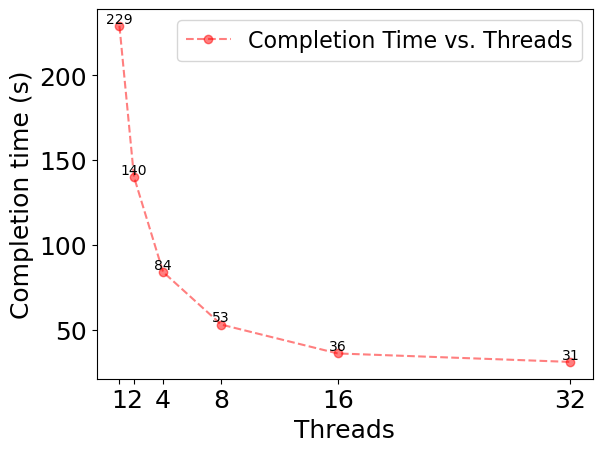

In [9]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

y = [229, 140, 84, 53, 36, 31]
x = [1, 2, 4, 8, 16, 32]

# 绘制柱状图
# plt.bar(x, y)
plt.plot(x, y, marker='o', color='red', linestyle='--', label='Completion Time vs. Threads', alpha=0.5)
# 可选：添加标题和标签
# plt.title('Simulation performance')
plt.xlabel('Threads',fontsize=18)
plt.ylabel('Completion time (s)',fontsize=18)
plt.legend(loc='upper right', fontsize=16)

# 标出每个柱的值
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

ax = plt.gca()  # 获取当前坐标轴对象
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # 设置x轴刻度的最大数量为5个
plt.xticks(x, x, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('simulation performance.png')
plt.show()




In [ ]:
import os
current_path = os.path.dirname(os.path.abspath(__file__))

In [8]:
# test atoms length
from dataclasses import dataclass
from typing import Optional
import ase
from fff.simulation.utils import read_from_string, write_to_string

@dataclass
class SimulationTask:
    atoms: ase.Atoms  # Structure to be run
    traj_id: int  # Which trajectory this came from
    ml_eng: float  # Energy predicted from machine learning model
    ml_std: Optional[float] = None  # Uncertainty of the model
import pickle
# path = r'/home/yxx/work/project/colmena/multisite_/my_test/non_linear_temp/task_queue_audit'
# with open(path, 'rb') as f:
#     task_queue_audit = pickle.load(f)
    
with open('/home/lizz_lab/cse30019698/project/colmena/multisite_/my_test/ga_simulation_test/task_queue_audit.pkl', 'rb') as f:
    task_queue_audit = pickle.load(f)
    
print(len(task_queue_audit))

100


In [18]:
atoms = task_queue_audit[0].atoms
atoms.set_center_of_mass([0,0,0])
xyz = write_to_string(atoms, 'xyz')
print(xyz.split('\n')[0])

42


In [2]:
calc = dict(calc='psi4', method='pbe0-d3', basis='aug-cc-pvdz', num_threads=1)
print(calc)
calc['num_threads'] = 2
print(calc)

{'calc': 'psi4', 'method': 'pbe0-d3', 'basis': 'aug-cc-pvdz', 'num_threads': 1}
{'calc': 'psi4', 'method': 'pbe0-d3', 'basis': 'aug-cc-pvdz', 'num_threads': 2}


In [7]:
# test timer callback
import threading
from time import sleep

def my_function():
    # 创建事件对象
    event = threading.Event()

    def timeout_callback():
        # 设置事件对象，表示超时
        event.set()
        print("Function timed out")

    # 创建计时器，设置超时时间为10秒，并指定超时回调函数
    t = 1.5
    for i in range(10):
        timer = threading.Timer(1, timeout_callback)
        try:
            # 启动计时器
            timer.start()

            # 执行函数操作
            # TODO: 在这里编写你的函数代码
            print(t)
            sleep(t)
            t-=0.1

        finally:
            # 取消计时器
            timer.cancel()

        # 检查事件对象是否被设置（即是否超时）
        if event.is_set():
            # 执行超时后的操作
            # TODO: 在这里编写超时后的代码
            print("Function timed out")
            event.clear()
            pass
        else:
            # 函数执行正常完成
            # TODO: 在这里编写函数正常完成后的代码
            print("Function completed normally")
            pass

def main():
    # 调用函数
    my_function()

main()

1.5
Function timed out


Function timed out
1.4
Function timed out
Function timed out
1.2999999999999998
Function timed out
Function timed out
1.1999999999999997
Function completed normally
1.0999999999999996
Function completed normally
0.9999999999999997
Function timed out
Function timed out
0.8999999999999997
Function completed normally
0.7999999999999997
Function completed normally
0.6999999999999997
Function completed normally
0.5999999999999998
Function completed normally


In [9]:
import pickle
from pathlib import Path
out_dir = Path('/home/yxx/work/project/colmena/multisite_/my_test/ga_simulation_test')
# with open(out_dir / 'task_queue_audit.pkl', 'rb') as f:
#     task_queue_audit = pickle.load(f)
with open(out_dir / 'length_time', 'rb') as fp:
    length_times = pickle.load(fp)
with open(out_dir / 'cpu_time', 'rb') as fp:
    core_times = pickle.load(fp)
print(length_times)
print(core_times)

[(12, 5.850254774093628), (15, 7.936183929443359), (18, 14.705122470855713), (21, 16.75410395860672), (24, 21.41688847541809), (27, 24.086347818374634), (30, 31.15443527698517), (33, 40.727830992804634), (36, 48.143983125686646), (39, 59.534986893335976), (42, 72.19054274559021), (45, 83.08321416378021), (48, 97.04547603925069), (51, 107.61373349598476), (54, 133.2091362476349), (57, 133.03949835896492), (60, 174.3393987417221), (63, 203.84687733650208), (66, 245.14138960838318), (69, 267.0610399246216), (72, 330.6697278022766), (75, 359.20263490080833)]
{1: 459.49200105667114, 2: 308.5443150997162, 4: 178.95574569702148, 8: 114.76378226280212, 12: 88.14041328430176, 16: 76.19267272949219, 20: 68.74859023094177, 24: 64.68302941322327, 28: 63.44424271583557, 32: 66.51880431175232, 36: 69.2843005657196, 40: 70.93301844596863, 44: 69.64240193367004, 48: 70.88759207725525, 52: 69.63654398918152, 56: 71.50614309310913, 60: 71.06448984146118, 64: 72.96044158935547}


In [3]:
from colmena.models import Result

result = Result(
    (('name',), {'a':1}),
    method="method",
    keep_inputs=True,
    task_info={"resources": {"num_cpus": 1, "num_gpus": 0}},
)
result.inputs[1]['cpu'] = 3
result.inputs[1]['gpu'] = 1
print(result.inputs[1])
for key, value in result.inputs[1].items():
    # if key in ['a','b','cpu','gpu']:
    print(key,value)

{'a': 1, 'cpu': 3, 'gpu': 1}
a 1
cpu 3
gpu 1


In [1]:
# test ant pheromone
import numpy as np
import matplotlib.pyplot as plt
import random

def add_train(methods_to_run,methods_completed,pheromone,task_sequence,nums=1):
    methods_completed[0] += 1
    # task_sequence.append('train')
    task_sequence.append('a')
    
def add_sampling(methods_to_run,methods_completed,pheromone,task_sequence, nums=1):
    methods_completed[1] += nums
    for i in range(nums):
        # task_sequence.append('sampling')
        task_sequence.append('b')
def add_simulation(methods_to_run,methods_completed,pheromone,task_sequence, nums=1):
    methods_completed[2] += nums
    for i in range(nums):
        # task_sequence.append('simulation')
        task_sequence.append('c')
def add_inference(methods_to_run,methods_completed,pheromone,task_sequence, nums=1):
    methods_completed[3] += nums
    for i in range(nums):
        # task_sequence.append('inference')
        task_sequence.append('d')
        
methods = ['train', 'sampling', 'simulation', 'inference']
task_types = {'a':0, 'b':1, 'c':2, 'd':3}
pheromone = np.zeros(4)
evaporation = 0.5

# generate task sequence
num_train = 4
num_simulation = 100
num_sampling = num_simulation
num_inference = 10
methods_to_run = np.array([num_train, num_sampling, num_simulation, num_inference])
methods_completed = np.array([0,0,0,0])
# task_sequence = []
# for i in range(10):
#     while np.any(methods_completed < methods_to_run):
#         if methods_completed[0] < (methods_completed[2]//20+1):
#             print('add train')
#             add_train(methods_to_run,methods_completed,pheromone,task_sequence)
#         if methods_completed[1] < methods_completed[0]*20:
#             print('add sampling')
#             nums = random.randint(1,10)
#             add_sampling(methods_to_run,methods_completed,pheromone,task_sequence,nums=nums)
#         if methods_completed[2] < methods_completed[1]:
#             print('add simulation')
#             nums = random.randint(1,methods_completed[1]-methods_completed[2])
#             add_simulation(methods_to_run,methods_completed,pheromone,task_sequence,nums=nums)
#         if random.random() < 0.5:
#             print('add inference')
#             add_inference(methods_to_run,methods_completed,pheromone,task_sequence)
def get_task_sequence(methods_to_run,methods_completed,pheromone):
    task_sequence = []
    methods_completed = np.array([0,0,0,10])
    for i in range(2):
        while np.any(methods_completed < methods_to_run):
            if methods_completed[0] < (methods_completed[2]//20+1):
                # print('add train')
                add_train(methods_to_run,methods_completed,pheromone,task_sequence)
            if methods_completed[1] < methods_completed[0]*20:
                # print('add sampling')
                nums = random.randint(1,10)
                add_sampling(methods_to_run,methods_completed,pheromone,task_sequence,nums=nums)
            if methods_completed[2] < methods_completed[1]:
                # print('add simulation')
                nums = random.randint(1,methods_completed[1]-methods_completed[2])
                add_simulation(methods_to_run,methods_completed,pheromone,task_sequence,nums=nums)
            if random.random() < 0.5:
                print('add inference')
                add_inference(methods_to_run,methods_completed,pheromone,task_sequence)
    return task_sequence
task_sequence = get_task_sequence(methods_to_run,methods_completed,pheromone)
print(methods_completed)
print(np.any(methods_to_run < methods_completed))
sequence1 = task_sequence
task_sequence = get_task_sequence(methods_to_run,methods_completed,pheromone)
sequence2 = task_sequence

add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
[0 0 0 0]
False
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference


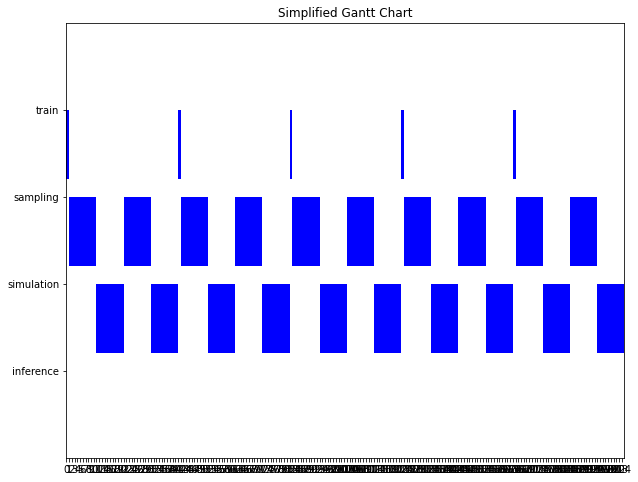

In [56]:
import matplotlib.pyplot as plt


tasks = task_sequence
fig, ax = plt.subplots(figsize=(10, 8))

for i, task in enumerate(tasks):
    task_type = task_types[task]
    ax.broken_barh([(i,1)],(task_type,0.8), facecolors='b')
    
ax.set_xlim(0,len(tasks))
ax.set_ylim(-1,4)
ax.invert_yaxis()
ax.set_xticks(range(len(tasks)))
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['train','sampling','simulation','inference'])
ax.set_title('Simplified Gantt Chart')

plt.show()

In [69]:
import math

def jaccard_similarity(seq1, seq2):
    set1 = set(seq1)
    set2 = set(seq2)
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    similarity = intersection / union
    return similarity

def levenshtein_similarity(seq1, seq2):
    m = len(seq1)
    n = len(seq2)
    
    # 创建一个二维数组来存储编辑距离
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # 初始化第一行和第一列
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # 动态规划计算编辑距离
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1]) + 1
    
    # 返回编辑距离
    distance = dp[m][n]
    max_length = max(m, n)
    similarity = 1 - (distance / max_length)
    return similarity

# 一个函数来计算子序列的相似度
def calculate_similarity(seq1, seq2):
    # 使用适当的方法来计算两个序列的相似度，例如编辑距离
    # return 0.8*jaccard_similarity(seq1, seq2)+0.2*levenshtein_similarity(seq1, seq2)
    return jaccard_similarity(seq1, seq2)

# 一个简单的滚动哈希函数
def rolling_hash(old_hash, old_value, new_value, window_size, base=256, mod=10007):
    new_hash = (old_hash - (ord(old_value) * (base ** (window_size - 1)) % mod) + mod) % mod
    new_hash = (new_hash * base + ord(new_value)) % mod
    return new_hash

# 使用滚动哈希和多个窗口大小检测重复子序列
def detect_repeats(task_sequence, min_window_size=4, max_window_size=100, similarity_threshold=0.8):
    
    base = 256  # 哈希基数
    mod = 1007  # 哈希模数
    
    if len(task_sequence) < min_window_size:
        return None

    # 存储每个窗口大小的哈希表
    hash_tables = {size: {} for size in range(min_window_size, max_window_size+1)}
    # 存储每个窗口大小的当前哈希值
    current_hashes = {size: 0 for size in range(min_window_size, max_window_size+1)}
    # 存储重复子序列的信息
    repeats_info = {}

    # 初始化每个窗口的哈希值
    for size in range(min_window_size, max_window_size+1):
        for i in range(size):
            current_hashes[size] = (current_hashes[size] * base + ord(task_sequence[i])) % mod

    # 检测重复子序列
    for i in range(len(task_sequence) - max_window_size + 1):
        for size in range(min_window_size, max_window_size+1):
            if i+size > len(task_sequence):
                continue

            start_index = i
            end_index = i + size
            subseq = task_sequence[start_index:end_index]
            current_hash = current_hashes[size]

            # 检查潜在重复子序列
            if current_hash in hash_tables[size]:
                # print('current_hash:',current_hash)
                # print('hash_tables:',hash_tables[size])
                candidate = hash_tables[size][current_hash]
                # print(candidate)
                similarity_score = calculate_similarity(subseq, candidate['subseq'])
                if similarity_score > similarity_threshold:
                    # 发现重复子序列，更新权重\
                    candidate['weight'] += math.sqrt(size)*similarity_score # 长度越长，权重越高,避免长序列是由重复的子序列重复多次而成，需要开根号
                    candidate['last_index'] = start_index
                    break
            else:
                # 添加新子序列到哈希表
                hash_tables[size][current_hash] = {'subseq': subseq, 'weight': size, 'last_index': start_index}

            # 更新哈希值（如果不是最后一个窗口）
            if end_index < len(task_sequence):
                old_value = task_sequence[start_index]
                new_value = task_sequence[end_index]
                new_hash = rolling_hash(current_hash, old_value, new_value, size, base, mod)
                current_hashes[size] = new_hash

    # 合并所有窗口大小的重复信息
    for size in range(min_window_size, max_window_size+1):
        for key in hash_tables[size]:
            subseq_info = hash_tables[size][key]
            subseq_info['length'] = size
            if subseq_info['subseq'] not in repeats_info:
                repeats_info[subseq_info['subseq']] = subseq_info
            else:
                repeats_info[subseq_info['subseq']]['weight'] += subseq_info['weight']

    return repeats_info
# 在序列生成后调用检测函数
task_sequence = get_task_sequence(methods_to_run,methods_completed,pheromone)
repeats_info = detect_repeats(''.join(task_sequence))
sorted_info = sorted(repeats_info.items(), key=lambda x: x[1]['weight'], reverse=True)
print(sorted_info)
print(len(repeats_info))

add train
add sampling
add simulation
add sampling
add simulation
add train
add sampling
add simulation
add sampling
add simulation
add train
add sampling
add simulation
add sampling
add simulation
add train
add sampling
add simulation
add sampling
add simulation
add train
add sampling
add simulation
add sampling
add simulation
[('bbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbcccc', {'subseq': 'bbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbcccc', 'weight': 179.63586137523464, 'last_index': 77, 'length': 48}), ('cccccc', {'subseq': 'cccccc', 'weight': 150, 'last_index': 11, 'length': 6}), ('ccccc', {'subseq': 'ccccc', 'weight': 145, 'last_index': 11, 'length': 5}), ('cccc', {'subseq': 'cccc', 'weight': 140, 'last_index': 11, 'length': 4}), ('ccccccc', {'subseq': 'ccccccc', 'weight': 140, 'last_index': 11, 'length': 7}), ('bbbbbb', {'subseq': 'bbbbbb', 'weight': 138, 'last_index': 1, 'length': 6}), ('bbbbb', {'subseq': 'bbbbb', 'weight': 135, 'last_index': 1, 'length': 5}), ('bbbbbbb', {'sub

In [2]:
import math

def jaccard_similarity(seq1, seq2):
    set1 = set(seq1)
    set2 = set(seq2)
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    similarity = intersection / union
    return similarity

def levenshtein_similarity(seq1, seq2):
    m = len(seq1)
    n = len(seq2)
    
    # 创建一个二维数组来存储编辑距离
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # 初始化第一行和第一列
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    
    # 动态规划计算编辑距离
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1]) + 1
    
    # 返回编辑距离
    distance = dp[m][n]
    max_length = max(m, n)
    similarity = 1 - (distance / max_length)
    return similarity

# 一个函数来计算子序列的相似度
def calculate_similarity(seq1, seq2):
    # 使用适当的方法来计算两个序列的相似度，例如编辑距离
    # return 0.8*jaccard_similarity(seq1, seq2)+0.2*levenshtein_similarity(seq1, seq2)
    return jaccard_similarity(seq1, seq2)

# 一个简单的滚动哈希函数
def rolling_hash(old_hash, old_value, new_value, window_size, base=256, mod=10 ** 9 +7):
    new_hash = (old_hash - (ord(old_value) * (base ** (window_size - 1)) % mod) + mod) % mod
    new_hash = (new_hash * base + ord(new_value)) % mod
    return new_hash


def detect_repeats(task_sequence, min_window_size=10, max_window_size=50, similarity_threshold=0.8):
    base = 256
    mod = 10 ** 9 +7
    
    if len(task_sequence) < min_window_size:
        return None

    hash_tables = {size: {} for size in range(min_window_size, max_window_size + 1)}
    current_hashes = {size: 0 for size in range(min_window_size, max_window_size + 1)}
    repeats_info = {}
    all_info = []
    # last_repeat_end = {size: -1 for size in range(min_window_size, max_window_size + 1)}

    for size in range(min_window_size, max_window_size + 1):
        for i in range(size):
            current_hashes[size] = (current_hashes[size] * base + ord(task_sequence[i])) % mod

    for i in range(len(task_sequence)):
        # print(current_hashes[5])
        for size in range(min_window_size, max_window_size + 1):
            # if i + size > len(task_sequence) or i <= last_repeat_end[size]:
            #     continue
            # if i + size >= len(task_sequence):
            #     break

            start_index = i
            end_index = i + size
            subseq = task_sequence[start_index:end_index]
            current_hash = current_hashes[size]
            if current_hash in hash_tables[size]:
                candidate = hash_tables[size][current_hash]
                if candidate['last_index'] + size <= start_index:
                    similarity_score = calculate_similarity(subseq, candidate['subseq'])
                    if similarity_score >= similarity_threshold:
                        candidate['weight'] += size
                        candidate['last_index'] = start_index
                        # last_repeat_end[size] = end_index - 1
            else:
                hash_tables[size][current_hash] = {'subseq': subseq, 'weight': size, 'last_index': start_index}

            if end_index < len(task_sequence):
                old_value = task_sequence[start_index]
                new_value = task_sequence[end_index]
                new_hash = rolling_hash(current_hash, old_value, new_value, size, base, mod)
                current_hashes[size] = new_hash
                # print(current_hashes[size])
    print(hash_tables)

    for size in range(min_window_size, max_window_size + 1):
        for key in hash_tables[size]:
            subseq_info = hash_tables[size][key]
            # subseq_info['length'] = size
            if subseq_info['subseq'] not in repeats_info:
                repeats_info[subseq_info['subseq']] = subseq_info
            else:
                repeats_info[subseq_info['subseq']]['weight'] += subseq_info['weight']
            all_info.append(subseq_info)

    return repeats_info, all_info

# 在序列生成后调用检测函数
task_sequence = get_task_sequence(methods_to_run,methods_completed,pheromone)
print(len(task_sequence))
repeats_info, all_info = detect_repeats(''.join(task_sequence))
sorted_info = sorted(repeats_info.items(), key=lambda x: x[1]['weight'], reverse=True)
sorted_all_info = sorted(all_info, key=lambda x: x['weight'], reverse=True)
print(''.join(task_sequence))
print(sorted_info)
print(sorted_all_info)
print(len(repeats_info))

add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
add inference
223
{10: {342239345: {'subseq': 'abbbbbbccc', 'weight': 10, 'last_index': 0}, 439081566: {'subseq': 'bbbbbbcccc', 'weight': 80, 'last_index': 199}, 734048834: {'subseq': 'bbbbbccccc', 'weight': 70, 'last_index': 200}, 245668911: {'subseq': 'bbbbcccccd', 'weight': 20, 'last_index': 57}, 220409496: {'subseq': 'bbbcccccdb', 'weight': 30, 'last_index': 140}, 753999305: {'subseq': 'bbcccccdbb', 'weight': 30, 'last_index': 95}, 352989450: {'subseq': 'bcccccdbbb', 'weight': 30, 'last_index': 96}, 694467291: {'subseq': 'cccccdbbbb', 'weight': 30, 'last_index': 97}, 616152838: {'subseq': 'ccccdbbbbb', 'weight': 30, 'last_index': 193}, 567653010: {'subseq': 'cccdbbbbbb', 'weight': 40, 'last_index': 194}, 151697126: {'subseq': 'ccdbbbbbbb', 'weight': 40, 'last_index': 195}, 666991571: {'subseq': 'cdbbbbb

In [88]:
print(''.join(sequence1))
test = 'ccccc'
last_repeat_end = -1
count = 0
for i in range(len(sequence1) - 4 + 1):
    if i <= last_repeat_end:
        continue
    if calculate_similarity(''.join(sequence1[i:i+5]), test)>0.8:
        print('find')
        count += 5*calculate_similarity(''.join(sequence1[i:i+5]), test)
        last_repeat_end = i+4

print(count)


abbbbbbbbbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbccccccccccbbbbbbbbbbccccccccccabbbbbbbbbbccccccccccbbbbbbbbbbcccccccccc
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
find
100.0


In [95]:
sequence1 = [1, 2, 3, 4, 5,6,7,8,9,10]
sequence2 = [1, 2, 3, 4, 6,7,8,9,10,11]
jaccard_similarity_score = jaccard_similarity(sequence1, sequence2)
levenshtein_similarity_score = levenshtein_similarity(sequence1, sequence2)
print("Jaccard Similarity:", jaccard_similarity_score)
print("Levenshtein Similarity:", levenshtein_similarity_score)

Jaccard Similarity: 0.8181818181818182
Levenshtein Similarity: 0.8


In [129]:
base = 256
mod = 10 ** 9 +7
size = 5
r_hash = 0
print('task_sequence:',task_sequence)
for i in range(size):
     r_hash = (r_hash * base + ord(task_sequence[i])) % mod
for i in range(len(task_sequence)):
    print(r_hash)
    if i+size < len(task_sequence):
        r_hash = rolling_hash(r_hash, task_sequence[i], task_sequence[i+size], size, base, mod)

task_sequence: ['a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c',

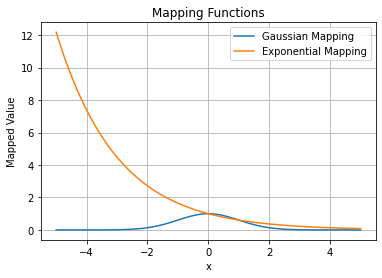

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_mapping(x, sigma):
    result = np.exp(-x**2 / (2 * sigma**2))
    return result

def exponential_mapping(x, scale):
    result = np.exp(-scale * x)
    return result

# 定义 x 的范围
x = np.linspace(-5, 5, 100)

# 计算高斯函数和指数函数的映射结果
sigma = 1.0
gaussian_result = gaussian_mapping(x, sigma)

scale = 0.5
exponential_result = exponential_mapping(x, scale)

# 绘制高斯函数和指数函数的图形
plt.plot(x, gaussian_result, label='Gaussian Mapping')
plt.plot(x, exponential_result, label='Exponential Mapping')
plt.xlabel('x')
plt.ylabel('Mapped Value')
plt.title('Mapping Functions')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
%load_ext autoreload
%autoreload 2

from fff.simulation import run_calculator
from pathlib import Path
import pickle
from ase.build import molecule
from dataclasses import dataclass
from fff.simulation.utils import read_from_string, write_to_string
import ase
from typing import Dict, Any, Optional

@dataclass
class SimulationTask:
    atoms: ase.Atoms  # Structure to be run
    traj_id: int  # Which trajectory this came from
    ml_eng: float  # Energy predicted from machine learning model
    ml_std: Optional[float] = None  # Uncertainty of the model
    
def cluster():
    xyz = """3

O       7.581982610000000     -0.663324770000000      5.483883860000000
H       8.362350460000000     -0.079370470000000      5.498567580000000
H       7.846055030000000     -1.464757200000000      5.041030880000000
"""
    return read_from_string(xyz, 'xyz')

a = cluster()

xyz = write_to_string(a, 'xyz')

calc = dict(calc='psi4', method='pbe0-d3', basis='aug-cc-pvdz', num_threads=8)
out_dir = Path('../my_test/ga_simulation_test')
    
result = run_calculator(xyz=xyz, calc=calc, temp_path="/tmp", cpu=8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  Threads set to 8 by Python driver.
  Threads set to 8 by Python driver.
